In [1]:
! pip install -Uq langgraph langchain_core langchain-google-genai

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.graph.state import CompiledStateGraph
from dotenv import load_dotenv
import os
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image,display

load_dotenv()

google_api = os.getenv('GEMINI_API_KEY')
llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=google_api)

c:\Users\hp\AppData\Local\anaconda3\envs\streamlit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def divide(a:int,b:int):
    ''' Divide a and b  
    Args:
    a: first int
    b:second int
    '''
    return a/b

def multiply(a:int,b:int):
    ''' Multiply a and b  
    Args:
    a: first int
    b:second int
    '''
    return a*b

def add(a:int,b:int):
    ''' Add a and b  
    Args:
    a: first int
    b:second int
    '''
    return a+b


tools: list[tool] = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

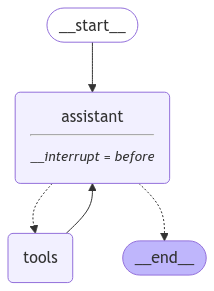

In [4]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

builder: StateGraph = StateGraph(MessagesState)

def assistant(state:MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg] + state["messages"])]}    

builder.add_node('assistant',assistant)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',tools_condition)

builder.add_edge('tools','assistant')

memory = MemorySaver()

graph : CompiledStateGraph = builder.compile(interrupt_before=['assistant'],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state.next

('assistant',)

In [7]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8a2f5002-d2e2-42c3-925b-156b90bcab2b')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbbafd-cfe1-682d-8000-2532095c3420'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-12-16T13:15:47.308548+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbbafd-cfda-6305-bfff-c5a24ebc4d55'}}, tasks=(PregelTask(id='2e47dd1f-c041-07ec-f555-c769606a78fe', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [8]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbbaff-d137-684f-8001-2b3ad2303783'}}

In [9]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [10]:
graph.get_state(thread)


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8a2f5002-d2e2-42c3-925b-156b90bcab2b'), HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='33f0df0c-3162-47aa-8387-76be4e66a979')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbbaff-d137-684f-8001-2b3ad2303783'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='33f0df0c-3162-47aa-8387-76be4e66a979')]}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2024-12-16T13:16:41.135726+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbbafd-cfe1-682d-8000-2532095c3420'}}, tasks=(PregelTask(id='36856748-ab05-2630-b0cf-bf2fdb6f4a43', name='assistant', path=('__pregel_pull', 'assistan

In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


In [13]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.
